In [43]:
# Cell 1: Import libraries and load cleaned AZ + ACS dataset

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, accuracy_score, f1_score

# Load the cleaned dataset
DATA_CSV = "az_business_acs_clean.csv"
df = pd.read_csv(DATA_CSV)

print("Shape of cleaned dataset:", df.shape)
print("Columns:")
print(df.columns.tolist())


Shape of cleaned dataset: (9907, 23)
Columns:
['business_id', 'name', 'city', 'state', 'postal_code', 'stars', 'review_count', 'attributes', 'categories', 'latitude', 'longitude', 'zip5', 'log_review_count', 'high_rating', 'price', 'price_missing', 'price_filled', 'is_restaurant', 'main_category_raw', 'main_category', 'median_income', 'pct_college', 'total_pop']


In [45]:
# Cell 2: Quick sanity checks on key variables


display(df.head())


print("\nBasic summary for main numeric columns:")
print(df[['stars', 'review_count', 'log_review_count',
          'price', 'price_filled', 'median_income',
          'pct_college', 'total_pop']].describe())

print("\nValue counts for high_rating (0/1):")
print(df['high_rating'].value_counts())


,business_id,name,city,state,postal_code,stars,review_count,attributes,categories,latitude,...,high_rating,price,price_missing,price_filled,is_restaurant,main_category_raw,main_category,median_income,pct_college,total_pop
0,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,85711,3.5,22,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...",32.223236,...,0,2.0,0,2.0,0,Department Stores,Other,52358.0,30.5,41201.0
1,rBmpy_Y1UbBx8ggHlyb7hA,Arizona Truck Outfitters,Tucson,AZ,85705,4.5,10,"{'DriveThru': 'False', 'BusinessAcceptsCreditC...","Automotive, Auto Parts & Supplies, Auto Custom...",32.229872,...,1,NaN,1,2.0,0,Automotive,Automotive,36606.0,20.1,54853.0
2,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,Tucson,AZ,85746,3.0,23,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese",32.132305,...,0,2.0,0,2.0,1,Restaurants,Restaurants,68506.0,17.8,44030.0
3,txyXRytGjwOXvS8s4sc-WA,Smoothie King,Tucson,AZ,85713,3.0,29,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Vitamins & Supplements, Ice Cream & Frozen Yog...",32.186794,...,0,2.0,0,2.0,0,Vitamins & Supplements,Other,50264.0,20.6,45615.0
4,eYxGFkxo6m3SYGVTh5m2nQ,Big Boyz Toyz Motorcycle Rentals,Tucson,AZ,85712,4.5,8,NaN,"Towing, Hotels & Travel, Automotive, Motorcycl...",32.250324,...,1,NaN,1,2.0,0,Towing,Other,48185.0,37.2,31964.0



Basic summary for main numeric columns:
             stars  review_count  log_review_count        price  price_filled  \
count  9907.000000   9907.000000       9907.000000  5000.000000   9907.000000   
mean      3.591703     41.644595          3.023118     1.724200      1.860805   
std       0.977562     86.363783          1.047063     0.656522      0.486342   
min       1.000000      5.000000          1.791759     1.000000      1.000000   
25%       3.000000      8.000000          2.197225     1.000000      2.000000   
50%       3.500000     15.000000          2.772589     2.000000      2.000000   
75%       4.500000     36.000000          3.610918     2.000000      2.000000   
max       5.000000   2126.000000          7.662468     4.000000      4.000000   

       median_income  pct_college     total_pop  
count    9779.000000  9833.000000   9862.000000  
mean    62856.765007    37.281247  36720.328331  
std     22846.463335    14.606603  13557.735678  
min     36606.000000     0.00

In [47]:
# Cell 3: Define feature lists and target variables

# Main outcome variables
target_reg = 'stars'         
target_clf = 'high_rating'   


numeric_features = [
    'price_filled',
    'price_missing',
    'is_restaurant',
    'log_review_count',
    'median_income',
    'pct_college',
    'total_pop'
]

# Categorical features:
categorical_features = [
    'main_category',
    'city'
]

# Check for missing values in selected features
print("Missing values in numeric features:")
print(df[numeric_features].isna().sum())

print("\nMissing values in categorical features:")
print(df[categorical_features].isna().sum())


Missing values in numeric features:
price_filled          0
price_missing         0
is_restaurant         0
log_review_count      0
median_income       128
pct_college          74
total_pop            45
dtype: int64

Missing values in categorical features:
main_category    0
city             0
dtype: int64


In [49]:
# Cell 4: Train/test split for both regression and classification tasks

# Features matrix
X = df[numeric_features + categorical_features].copy()

# Targets
y_reg = df[target_reg].copy()
y_clf = df[target_clf].copy()

# Train/test split (stratify by high_rating to balance class distribution)
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print("Share of high_rating = 1 in train / test:")
print(y_clf_train.mean(), y_clf_test.mean())


Train size: 7925 Test size: 1982
Share of high_rating = 1 in train / test:
0.4889589905362776 0.48890010090817354


In [50]:
# Cell 5: Define preprocessing pipeline for numeric and categorical features

# Numeric pipeline: impute missing with median, then standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing with "Missing", then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

print("Preprocessor ready.")


Preprocessor ready.


In [53]:
# Cell 6: Task A - Baseline Linear Regression model for stars

# Build pipeline: preprocessing + LinearRegression
regressor_lr = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# Fit on training data
regressor_lr.fit(X_train, y_reg_train)

# Predict on test data
y_reg_pred = regressor_lr.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = mean_squared_error(y_reg_test, y_reg_pred, squared=False)
r2 = r2_score(y_reg_test, y_reg_pred)

print("Linear Regression (stars) - Test performance")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")


Linear Regression (stars) - Test performance
MAE : 0.786
RMSE: 0.961
R^2 : 0.041


D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [54]:
# Cell 7: Task B - Baseline Logistic Regression model for high_rating

# Build pipeline: preprocessing + LogisticRegression
classifier_lr = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

# Fit on training data
classifier_lr.fit(X_train, y_clf_train)

# Predict probabilities and class labels on test data
y_clf_proba = classifier_lr.predict_proba(X_test)[:, 1]
y_clf_pred = classifier_lr.predict(X_test)

# Compute evaluation metrics
auc = roc_auc_score(y_clf_test, y_clf_proba)
acc = accuracy_score(y_clf_test, y_clf_pred)
f1 = f1_score(y_clf_test, y_clf_pred)

print("Logistic Regression (high_rating) - Test performance")
print(f"AUC      : {auc:.3f}")
print(f"Accuracy : {acc:.3f}")
print(f"F1 score : {f1:.3f}")


Logistic Regression (high_rating) - Test performance
AUC      : 0.606
Accuracy : 0.586
F1 score : 0.607


In [55]:
# Cell 8: Nested Linear Regression - business-only vs business + neighborhood

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define feature blocks
business_numeric = ['price_filled', 'price_missing', 'is_restaurant', 'log_review_count']
neighborhood_numeric = ['median_income', 'pct_college', 'total_pop']
categorical_features = ['main_category', 'city']

# Preprocessor for business-only model
preprocess_business = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), business_numeric),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Preprocessor for business + neighborhood model
preprocess_full = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), business_numeric + neighborhood_numeric),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Pipeline: business-only
reg_business = Pipeline(steps=[
    ('preprocess', preprocess_business),
    ('model', LinearRegression())
])

# Pipeline: business + neighborhood
reg_full = Pipeline(steps=[
    ('preprocess', preprocess_full),
    ('model', LinearRegression())
])

# Fit models
reg_business.fit(X_train, y_reg_train)
reg_full.fit(X_train, y_reg_train)

# Predict on test set
y_pred_business = reg_business.predict(X_test)
y_pred_full = reg_full.predict(X_test)

# Evaluate
def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_b, rmse_b, r2_b = eval_reg(y_reg_test, y_pred_business)
mae_f, rmse_f, r2_f = eval_reg(y_reg_test, y_pred_full)

print("Business-only model (stars)")
print(f"  MAE : {mae_b:.3f}")
print(f"  RMSE: {rmse_b:.3f}")
print(f"  R^2 : {r2_b:.33f}")

print("\nBusiness + neighborhood model (stars)")
print(f"  MAE : {mae_f:.3f}")
print(f"  RMSE: {rmse_f:.3f}")
print(f"  R^2 : {r2_f:.3f}")

print("\nR^2 gain from adding neighborhood features:", f"{(r2_f - r2_b):.3f}")


Business-only model (stars)
  MAE : 0.795
  RMSE: 0.969
  R^2 : 0.024622597111718547147063418378821

Business + neighborhood model (stars)
  MAE : 0.786
  RMSE: 0.961
  R^2 : 0.041

R^2 gain from adding neighborhood features: 0.016


D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [56]:
# Cell 9: Nested Logistic Regression - business-only vs business + neighborhood

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Business-only classifier
clf_business = Pipeline(steps=[
    ('preprocess', preprocess_business),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

# Business + neighborhood classifier
clf_full = Pipeline(steps=[
    ('preprocess', preprocess_full),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

# Fit models
clf_business.fit(X_train, y_clf_train)
clf_full.fit(X_train, y_clf_train)

# Predict on test set
proba_business = clf_business.predict_proba(X_test)[:, 1]
pred_business = clf_business.predict(X_test)

proba_full = clf_full.predict_proba(X_test)[:, 1]
pred_full = clf_full.predict(X_test)

def eval_clf(y_true, y_proba, y_pred):
    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return auc, acc, f1

auc_b, acc_b, f1_b = eval_clf(y_clf_test, proba_business, pred_business)
auc_f, acc_f, f1_f = eval_clf(y_clf_test, proba_full, pred_full)

print("Business-only model (high_rating)")
print(f"  AUC     : {auc_b:.3f}")
print(f"  Accuracy: {acc_b:.3f}")
print(f"  F1      : {f1_b:.3f}")

print("\nBusiness + neighborhood model (high_rating)")
print(f"  AUC     : {auc_f:.3f}")
print(f"  Accuracy: {acc_f:.3f}")
print(f"  F1      : {f1_f:.3f}")

print("\nAUC gain from adding neighborhood features:", f"{(auc_f - auc_b):.3f}")



Business-only model (high_rating)
  AUC     : 0.576
  Accuracy: 0.550
  F1      : 0.575

Business + neighborhood model (high_rating)
  AUC     : 0.606
  Accuracy: 0.586
  F1      : 0.607

AUC gain from adding neighborhood features: 0.030


In [57]:
# Cell 10: Extract feature names and coefficients from full linear and logistic models

import pandas as pd
import numpy as np

# Helper to get feature names from a ColumnTransformer
def get_feature_names(column_transformer):
    """
    Extract feature names from a fitted ColumnTransformer.
    Returns a list of feature names after preprocessing.
    """
    feature_names = []

    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue

        if hasattr(transformer, 'named_steps'):
            last_step = list(transformer.named_steps.values())[-1]
        else:
            last_step = transformer

        if hasattr(last_step, 'get_feature_names_out'):
            try:
                fn = last_step.get_feature_names_out(cols)
            except TypeError:
                fn = last_step.get_feature_names_out()
            feature_names.extend(fn)
        else:
            feature_names.extend(cols)

    return feature_names


# Linear regression coefficients
full_ct = reg_full.named_steps['preprocess']
lin_model = reg_full.named_steps['model']

lin_features = get_feature_names(full_ct)
lin_coefs = lin_model.coef_

coef_df_lin = pd.DataFrame({
    'feature': lin_features,
    'coef': lin_coefs
}).sort_values(by='coef', key=lambda s: s.abs(), ascending=False)

print("Top 15 features by absolute coefficient (Linear Regression):")
display(coef_df_lin.head(15))


#  Logistic regression coefficients
full_ct_clf = clf_full.named_steps['preprocess']
log_model = clf_full.named_steps['model']

log_features = get_feature_names(full_ct_clf)
log_coefs = log_model.coef_[0]   # shape (1, n_features)

coef_df_log = pd.DataFrame({
    'feature': log_features,
    'coef': log_coefs,
    'odds_ratio': np.exp(log_coefs)
}).sort_values(by='coef', key=lambda s: s.abs(), ascending=False)

print("Top 15 features by absolute coefficient (Logistic Regression):")
display(coef_df_log.head(15))


Top 15 features by absolute coefficient (Linear Regression):


,feature,coef
39,city_Picture Rocks,1.672137
46,city_TUCSON AP,-1.644920
23,city_Arizona,1.379219
38,city_Oro valley,-1.259310
27,city_Catalina Foothills,1.239874
20,main_category_Real Estate,-1.010980
44,city_Summerhaven,-0.925915
31,city_Green Valle,-0.920560
42,city_Santa Rita,0.917288
29,city_Corona de Tucson,0.846043


Top 15 features by absolute coefficient (Logistic Regression):


,feature,coef,odds_ratio
32,city_Green Valley,-1.347321,0.259936
12,main_category_Fast Food,-1.296319,0.273537
20,main_category_Real Estate,-1.277251,0.278803
35,city_Mount Lemmon,-1.172373,0.309631
29,city_Corona de Tucson,0.921935,2.514151
8,main_category_Auto Repair,0.760810,2.140009
10,main_category_Beauty & Spas,0.602139,1.826021
43,city_South Tucson,-0.592567,0.552906
17,main_category_Local Services,0.577772,1.782063
49,"city_Tucson, Arizona",0.568054,1.764829


In [58]:
# Cell 11: Ridge Regression with cross-validation for stars

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Use the same full preprocessor
ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_full),
    ('model', Ridge())
])

# Hyperparameter grid for alpha
alpha_grid = {'model__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}

ridge_cv = GridSearchCV(
    ridge_pipeline,
    param_grid=alpha_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

ridge_cv.fit(X_train, y_reg_train)

print("Best alpha for Ridge:", ridge_cv.best_params_)

# Evaluate on test set
y_pred_ridge = ridge_cv.predict(X_test)

mae_r = mean_absolute_error(y_reg_test, y_pred_ridge)
rmse_r = mean_squared_error(y_reg_test, y_pred_ridge, squared=False)
r2_r = r2_score(y_reg_test, y_pred_ridge)

print("Ridge Regression (stars) - Test performance")
print(f"MAE : {mae_r:.3f}")
print(f"RMSE: {rmse_r:.3f}")
print(f"R^2 : {r2_r:.3f}")


Best alpha for Ridge: {'model__alpha': 10.0}
Ridge Regression (stars) - Test performance
MAE : 0.786
RMSE: 0.960
R^2 : 0.042


D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
# Cell 12: Random Forest classifier as a non-linear benchmark for high_rating

from sklearn.ensemble import RandomForestClassifier

# Dense preprocessor (same logic, but enforce dense output)
preprocess_dense = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), business_numeric + neighborhood_numeric),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    sparse_threshold=0.0  # force dense output
)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_dense),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced_subsample'
    ))
])

rf_pipeline.fit(X_train, y_clf_train)

# Evaluate on test set
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]
rf_pred = rf_pipeline.predict(X_test)

auc_rf = roc_auc_score(y_clf_test, rf_proba)
acc_rf = accuracy_score(y_clf_test, rf_pred)
f1_rf = f1_score(y_clf_test, rf_pred)

print("Random Forest (high_rating) - Test performance")
print(f"AUC      : {auc_rf:.3f}")
print(f"Accuracy : {acc_rf:.3f}")
print(f"F1 score : {f1_rf:.3f}")

# Feature importance
rf_ct = rf_pipeline.named_steps['preprocess']
rf_model = rf_pipeline.named_steps['model']

rf_features = get_feature_names(rf_ct)
rf_importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': rf_features,
    'importance': rf_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 15 features by feature importance (Random Forest):")
display(fi_df.head(15))


Random Forest (high_rating) - Test performance
AUC      : 0.572
Accuracy : 0.554
F1 score : 0.555

Top 15 features by feature importance (Random Forest):


,feature,importance
3,log_review_count,0.598862
5,pct_college,0.066388
6,total_pop,0.063053
4,median_income,0.062559
0,price_filled,0.037690
2,is_restaurant,0.025653
1,price_missing,0.023573
19,main_category_Other,0.015596
13,main_category_Food,0.007765
22,main_category_Shopping,0.007357


In [60]:
# Cell 13: Build summary tables for model performance 

import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Regression metrics helper
def eval_regression(model, X_test, y_true):
    """Return MAE, RMSE, R^2 for a regression model."""
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

#Classification metrics helpe
def eval_classification(model, X_test, y_true):
    """Return AUC, Accuracy, F1 for a classification model."""
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_true, y_proba)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return auc, acc, f1

# Regression models: business-only, full, ridge
mae_b, rmse_b, r2_b = eval_regression(reg_business, X_test, y_reg_test)
mae_f, rmse_f, r2_f = eval_regression(reg_full, X_test, y_reg_test)
mae_r, rmse_r, r2_r = eval_regression(ridge_cv.best_estimator_, X_test, y_reg_test)

reg_results = pd.DataFrame({
    'model': ['Linear (business only)',
              'Linear (business + neighborhood)',
              'Ridge (business + neighborhood)'],
    'MAE': [mae_b, mae_f, mae_r],
    'RMSE': [rmse_b, rmse_f, rmse_r],
    'R2': [r2_b, r2_f, r2_r]
})

print("Regression models - test performance")
display(reg_results)

# Classification models: business-only, full, Random Forest
auc_b, acc_b, f1_b = eval_classification(clf_business, X_test, y_clf_test)
auc_f, acc_f, f1_f = eval_classification(clf_full, X_test, y_clf_test)
auc_rf, acc_rf, f1_rf = eval_classification(rf_pipeline, X_test, y_clf_test)

clf_results = pd.DataFrame({
    'model': ['Logistic (business only)',
              'Logistic (business + neighborhood)',
              'Random Forest (business + neighborhood)'],
    'AUC': [auc_b, auc_f, auc_rf],
    'Accuracy': [acc_b, acc_f, acc_rf],
    'F1': [f1_b, f1_f, f1_rf]
})

print("Classification models - test performance")
display(clf_results)

# Optionally save tables for later use (CSV or LaTeX)
reg_results.to_csv("model_performance_regression.csv", index=False)
clf_results.to_csv("model_performance_classification.csv", index=False)




Regression models - test performance


D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\ANACONDA\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,RMSE,R2
0,Linear (business only),0.794693,0.969273,0.024623
1,Linear (business + neighborhood),0.785719,0.961206,0.040791
2,Ridge (business + neighborhood),0.786026,0.960416,0.042366


Classification models - test performance


,model,AUC,Accuracy,F1
0,Logistic (business only),0.576080,0.549950,0.575238
1,Logistic (business + neighborhood),0.606372,0.586276,0.607280
2,Random Forest (business + neighborhood),0.572253,0.553986,0.554884


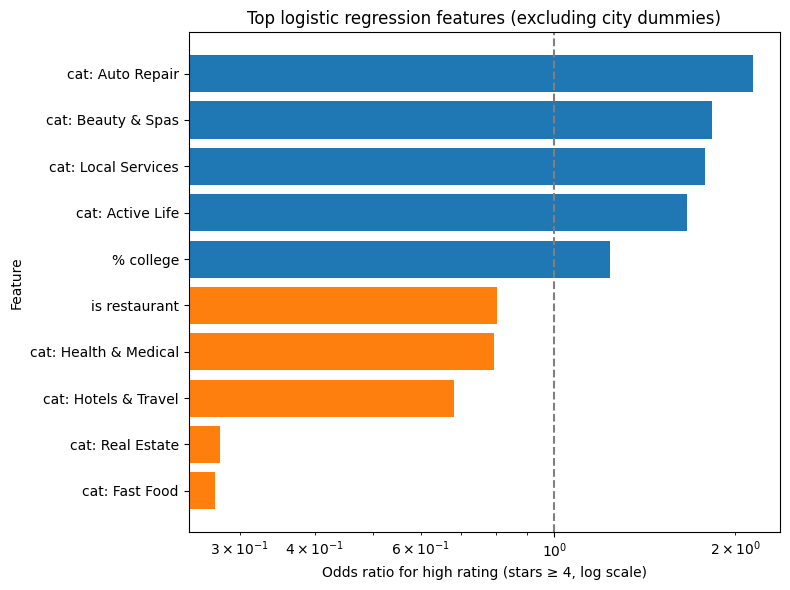

In [61]:
# Cell 14: Plot top logistic regression coefficients (odds ratios)

import matplotlib.pyplot as plt
import numpy as np

# coef_log_nc and top_coef_log have already been created before

# Sort for plotting
top_coef_log = coef_log_nc.sort_values('abs_coef', ascending=False).head(top_k)
top_coef_log = top_coef_log.sort_values('odds_ratio')

top_coef_log['label'] = top_coef_log['feature'].apply(prettify_feature_name)


colors = ['tab:blue' if or_val >= 1.0 else 'tab:orange'
          for or_val in top_coef_log['odds_ratio']]

plt.figure(figsize=(8, 6))

plt.barh(top_coef_log['label'], top_coef_log['odds_ratio'], color=colors)
plt.axvline(1.0, linestyle='--', color='gray')

plt.xscale('log')  # log scale for odds ratios
plt.xlabel("Odds ratio for high rating (stars ≥ 4, log scale)")
plt.ylabel("Feature")
plt.title("Top logistic regression features (excluding city dummies)")

plt.tight_layout()
plt.show()


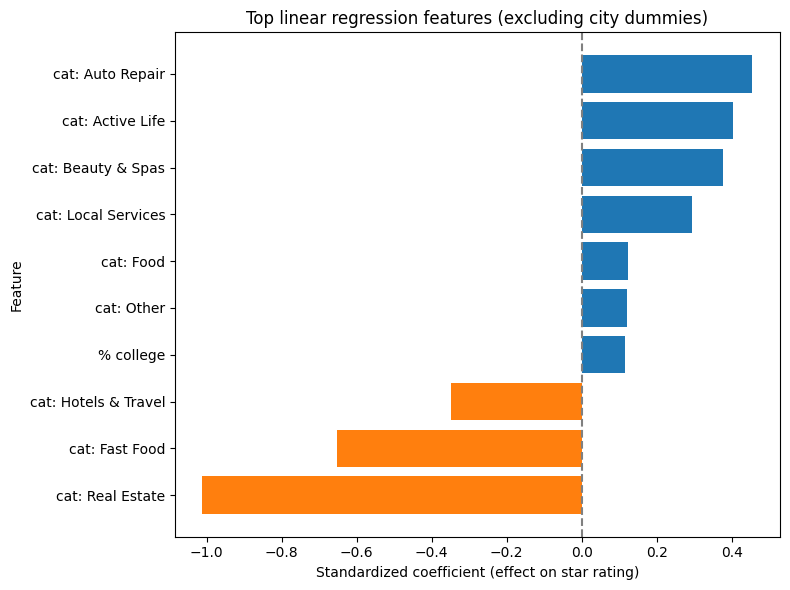

In [62]:
# New version of Cell 15 plotting part: positive vs negative colored bars

top_coef_lin = coef_lin_nc.sort_values('abs_coef', ascending=False).head(top_k)
top_coef_lin = top_coef_lin.sort_values('coef')
top_coef_lin['label'] = top_coef_lin['feature'].apply(prettify_feature_name)

# Color by sign of coefficient
colors_lin = ['tab:blue' if c >= 0 else 'tab:orange'
              for c in top_coef_lin['coef']]

plt.figure(figsize=(8, 6))

plt.barh(top_coef_lin['label'], top_coef_lin['coef'], color=colors_lin)

plt.axvline(0.0, linestyle='--', color='gray')
plt.xlabel("Standardized coefficient (effect on star rating)")
plt.ylabel("Feature")
plt.title("Top linear regression features (excluding city dummies)")

plt.tight_layout()
plt.show()


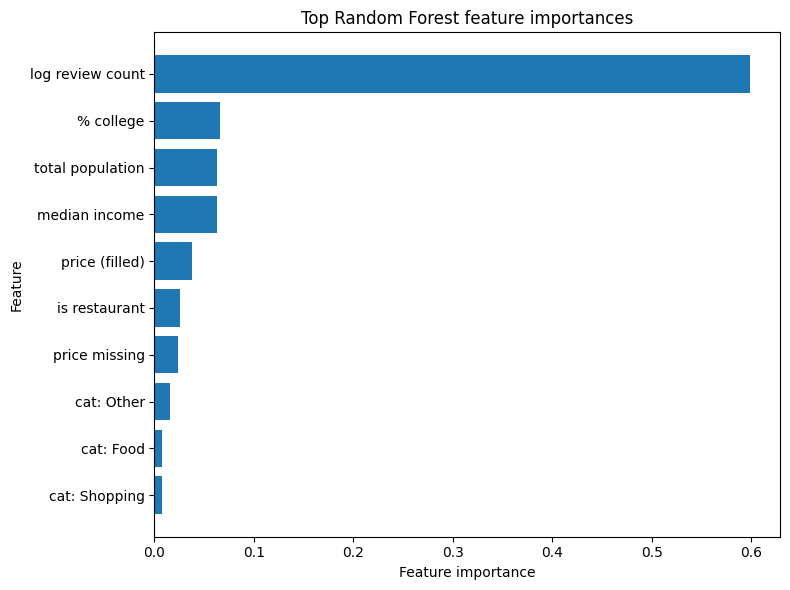

In [63]:
# Cell 16: Plot top Random Forest feature importances

# Make a copy
fi = fi_df.copy()


# Select top 10 features
top_importance = fi.sort_values('importance', ascending=False).head(top_k)

# Prettify labels
top_importance['label'] = top_importance['feature'].apply(prettify_feature_name)

# Sort for plotting
top_importance = top_importance.sort_values('importance')

plt.figure(figsize=(8, 6))

plt.barh(top_importance['label'], top_importance['importance'])

plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Top Random Forest feature importances")

plt.tight_layout()

plt.show()


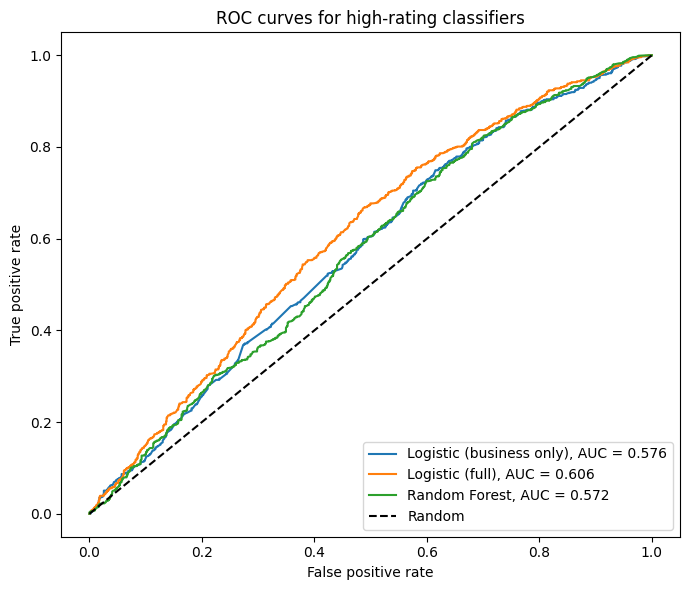

In [64]:
# Cell 17: Plot ROC curves for the three classification models

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

# 1) Logistic - business only
proba_b = clf_business.predict_proba(X_test)[:, 1]
fpr_b, tpr_b, _ = roc_curve(y_clf_test, proba_b)
auc_b = auc(fpr_b, tpr_b)
plt.plot(fpr_b, tpr_b, label=f"Logistic (business only), AUC = {auc_b:.3f}")

# 2) Logistic - business + neighborhood
proba_f = clf_full.predict_proba(X_test)[:, 1]
fpr_f, tpr_f, _ = roc_curve(y_clf_test, proba_f)
auc_f = auc(fpr_f, tpr_f)
plt.plot(fpr_f, tpr_f, label=f"Logistic (full), AUC = {auc_f:.3f}")

# 3) Random Forest
proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_clf_test, proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest, AUC = {auc_rf:.3f}")

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves for high-rating classifiers")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


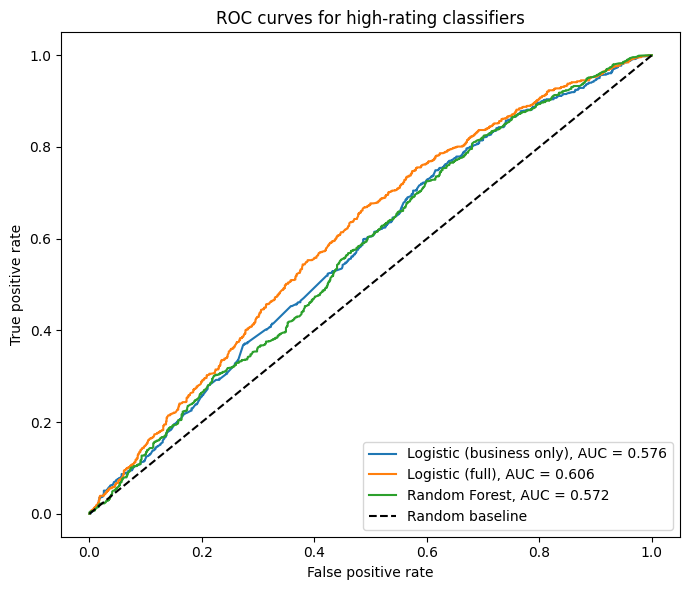

In [65]:
# Cell 17: ROC curves for the three classification models

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))

# 1) Logistic - business only
proba_b = clf_business.predict_proba(X_test)[:, 1]
fpr_b, tpr_b, _ = roc_curve(y_clf_test, proba_b)
auc_b = auc(fpr_b, tpr_b)
ax.plot(fpr_b, tpr_b, label=f"Logistic (business only), AUC = {auc_b:.3f}")

# 2) Logistic - business + neighborhood
proba_f = clf_full.predict_proba(X_test)[:, 1]
fpr_f, tpr_f, _ = roc_curve(y_clf_test, proba_f)
auc_f = auc(fpr_f, tpr_f)
ax.plot(fpr_f, tpr_f, label=f"Logistic (full), AUC = {auc_f:.3f}")

# 3) Random Forest
proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_clf_test, proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, label=f"Random Forest, AUC = {auc_rf:.3f}")

# Random baseline
ax.plot([0, 1], [0, 1], "k--", label="Random baseline")

ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves for high-rating classifiers")
ax.legend(loc="lower right")

plt.tight_layout()
fig.savefig("METH_cell17_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()
